In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer, Bidirectional, GRU, Input, Dropout, Add, Dense, MultiHeadAttention, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the CSV file
data = pd.read_csv(r'C:\Users\DELL\Desktop\Internship\nppdp.csv')

# Extract features and labels
features = data.drop(columns=['emotion_label'])
emotion_labels = data['emotion_label']

# Standardize the features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, emotion_labels, test_size=0.2, random_state=42)
new_y=y_test
# Assuming each sequence has the same length, reshape accordingly
input_dim = len(features[0])
original_size = X_train.shape[0] * X_train.shape[1]  # Total elements in the original array

# Calculate time_steps
time_steps = original_size // (X_train.shape[0] * input_dim)

# Reshape features to 3D (time steps, features) for GRU input
X_train = X_train.reshape((X_train.shape[0], time_steps, input_dim))
X_test = X_test.reshape((X_test.shape[0], time_steps, input_dim))

y_train = tf.keras.utils.to_categorical(y_train-1, num_classes=8) # Assuming 8 classes for emotion
y_test = tf.keras.utils.to_categorical(y_test-1, num_classes=8)

# Data Augmentation
def augment_data(X, y):
    augmented_X, augmented_y = [], []
    for i in range(len(X)):
        x = X[i]
        # Add noise
        noise = np.random.normal(0, 0.1, x.shape)
        x_noisy = x + noise
        augmented_X.append(x_noisy)
        augmented_y.append(y[i])
    augmented_X = np.array(augmented_X)
    augmented_y = np.array(augmented_y)
    return np.concatenate((X, augmented_X)), np.concatenate((y, augmented_y))

X_train, y_train = augment_data(X_train, y_train)

# Define the attention mechanism layer
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],), initializer="zeros", trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.nn.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = tf.reduce_sum(x * a, axis=1)
        return output

# Define the input shape based on the number of features and time steps
input_shape = (time_steps, input_dim)

# Input layer
inputs = Input(shape=input_shape)

# Bidirectional GRU layers with residual connections and batch normalization
x_ = Bidirectional(GRU(128, return_sequences=True))(inputs)
x_ = BatchNormalization()(x_)
x_res = Bidirectional(GRU(128, return_sequences=True))(x_)
x_res = BatchNormalization()(x_res)
x_ = Add()([x_, x_res])  # Residual connection
x_ = Dropout(0.3)(x_)

# Additional Bidirectional GRU layer with dropout and batch normalization
x_ = Bidirectional(GRU(128, return_sequences=True))(x_)
x_ = BatchNormalization()(x_)
x_ = Dropout(0.3)(x_)

# Multi-Head Attention mechanism
att = MultiHeadAttention(num_heads=4, key_dim=64)(x_, x_)

# Attention mechanism
x_ = Attention()(att)

# Fully connected layers with L2 regularization and batch normalization
x_ = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x_)
x_ = BatchNormalization()(x_)
x_ = Dropout(0.3)(x_)
x_ = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x_)
x_ = BatchNormalization()(x_)
x_ = Dropout(0.3)(x_)

# Output layer for emotion classification
output = Dense(8, activation='softmax', name='emotion_output')(x_)

# Create the model
model = Model(inputs, output)

# Learning Rate Scheduler function
def lr_schedule(epoch, lr):
    if epoch > 10:
        lr = lr * 0.999
    return lr

# Compile the model with gradient clipping
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping and Checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
lr_scheduler = LearningRateScheduler(lr_schedule)

# Print the model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, checkpoint, lr_scheduler])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)

# Print the evaluation results
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 1, 90)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_3               │ (None, 1, 256)            │         168,960 │ input_layer_1[0][0]        │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_5         │ (None, 1, 256)            │           1,024 │ bidirectional_3[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_4               │ (None, 1, 256)            │         296,448 │ batch_normalization_5[0][… │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_6         │ (None, 1, 256)            │           1,024 │ bidirectional_4[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_1 (Add)                   │ (None, 1, 256)            │               0 │ batch_normalization_5[0][… │
│                               │                           │                 │ batch_normalization_6[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_5 (Dropout)           │ (None, 1, 256)            │               0 │ add_1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_5               │ (None, 1, 256)            │         296,448 │ dropout_5[0][0]            │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_7         │ (None, 1, 256)            │           1,024 │ bidirectional_5[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_6 (Dropout)           │ (None, 1, 256)            │               0 │ batch_normalization_7[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_1        │ (None, 1, 256)            │         263,168 │ dropout_6[0][0],           │
│ (MultiHeadAttention)          │                           │                 │ dropout_6[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ attention_1 (Attention)       │ (None, 256)               │          65,792 │ multi_head_attention_1[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 128)               │          32,896 │ attention_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 1,136,328 (4.33 MB)

 Trainable params: 1,134,408 (4.33 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/100


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


175/180 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5638 - loss: 3.5624

C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


180/180 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.5675 - loss: 3.5373 - val_accuracy: 0.7736 - val_loss: 1.6720 - learning_rate: 0.0010
Epoch 2/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7838 - loss: 1.4732 - val_accuracy: 0.8306 - val_loss: 0.9106 - learning_rate: 0.0010
Epoch 3/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8229 - loss: 0.8305 - val_accuracy: 0.8111 - val_loss: 0.6970 - learning_rate: 0.0010
Epoch 4/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8419 - loss: 0.6012 - val_accuracy: 0.8319 - val_loss: 0.5900 - learning_rate: 0.0010
Epoch 5/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8605 - loss: 0.4933 - val_accuracy: 0.8486 - val_loss: 0.5062 - learning_rate: 0.0010
Epoch 6/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8798 - loss: 0.4130 - val_accuracy: 0.8208 - val_loss: 0.5545 - learning_rate: 0.0010
Epoch 7/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8966 - loss: 0.3606 - val

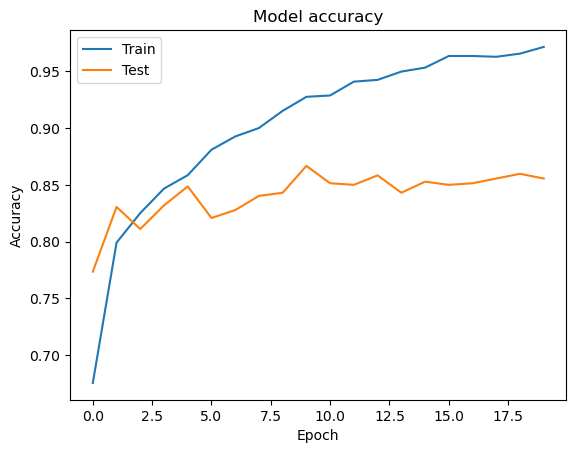

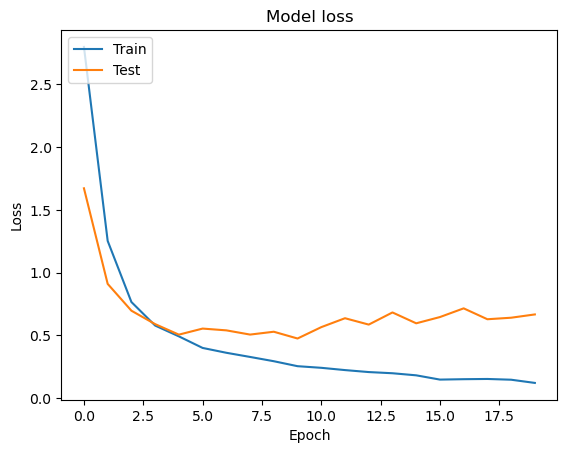

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8622 - loss: 0.4549 
Test accuracy: 0.8666666746139526


In [ ]:
import matplotlib.pyplot as plt
# Plot training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

# Save the model
# model.save('speech_emotion_recognition_cnn.h5')


In [ ]:
model.save('speech_emotion_recognition_temp.h5')

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
Confusion Matrix:
[[112   0   0   0   1   0   1   0]
 [  0  84   0   4   0   0   2   0]
 [  0   1  38  16   0   0  28   0]
 [  0   0  20  66   0   0   9   3]
 [  0   0   1   0  77   0   0   0]
 [  0   1   0   0   0  86   0   0]
 [  0   0   5   4   0   0  75   0]
 [  0   0   0   0   0   0   0  86]]


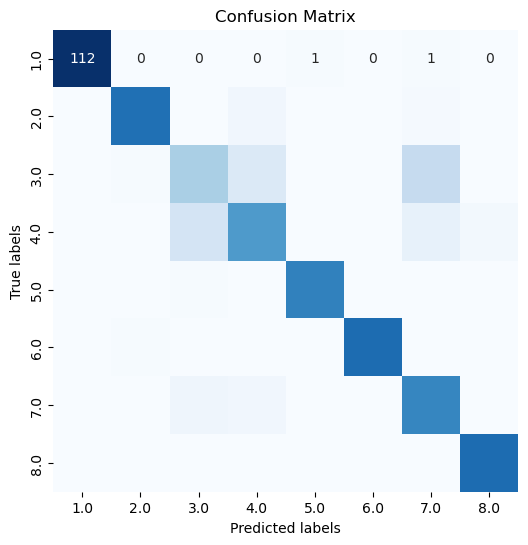

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1) +1
# Ensure y_test and y_pred are of the same type and dimension
new_y = np.array(new_y)  # Convert to numpy array if necessary
y_pred = np.array(y_pred)  # Convert to numpy array if necessary

# Create confusion matrix
cm = confusion_matrix(new_y, y_pred)

# Print confusion matrix as text
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=np.unique(emotion_labels),  # Use unique classes as labels
            yticklabels=np.unique(emotion_labels))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
# Calculate accuracy for each class
class_accuracy = cm.diagonal() / cm.sum(axis=1)

# Print accuracy for each class
for i, acc in enumerate(class_accuracy):
    print(f"Accuracy for class {i+1}: {acc:.4f}")

# Overall accuracy
overall_accuracy = accuracy_score(new_y, y_pred)
print(f"\nOverall Accuracy: {overall_accuracy:.4f}")

Accuracy for class 1: 0.9825
Accuracy for class 2: 0.9333
Accuracy for class 3: 0.4578
Accuracy for class 4: 0.6735
Accuracy for class 5: 0.9872
Accuracy for class 6: 0.9885
Accuracy for class 7: 0.8929
Accuracy for class 8: 1.0000

Overall Accuracy: 0.8667
